In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/march-machine-learning-mania-2025/Conferences.csv
/kaggle/input/march-machine-learning-mania-2025/SeedBenchmarkStage1.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneyDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/WRegularSeasonCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneySeedRoundSlots.csv
/kaggle/input/march-machine-learning-mania-2025/MRegularSeasonDetailedResults.csv
/kaggle/input/march-machine-learning-mania-2025/MNCAATourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/MGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/WSecondaryTourneyCompactResults.csv
/kaggle/input/march-machine-learning-mania-2025/WGameCities.csv
/kaggle/input/march-machine-learning-mania-2025/MSeasons.csv
/kaggle/input/march-machine-learning-mania-2025/WNCAATourneySlots.csv
/kaggle/input/march-machine-learning-mania-2025/MSecondaryTourneyTeams.csv
/kaggle/input/march-machine-learning-mania-20

In [2]:
import numpy as np
import pandas as pd
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_absolute_error, brier_score_loss
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load datasets
data_path = '/kaggle/input/march-machine-learning-mania-2025/**'
datasets = {p.split('/')[-1].split('.')[0]: pd.read_csv(p, encoding='latin-1') for p in glob.glob(data_path)}

In [4]:
# Display a few rows of each dataset
for dataset_name, dataset in datasets.items():
    print(f"First few rows of {dataset_name}:")
    print(dataset.head())  # Display the first 5 rows
    print("\n" + "="*50 + "\n")  # Separator for readability

First few rows of Conferences:
  ConfAbbrev                   Description
0      a_sun       Atlantic Sun Conference
1      a_ten        Atlantic 10 Conference
2        aac  American Athletic Conference
3        acc     Atlantic Coast Conference
4        aec       America East Conference


First few rows of SeedBenchmarkStage1:
               ID  Pred
0  2021_1101_1102  0.50
1  2021_1101_1103  0.50
2  2021_1101_1104  0.14
3  2021_1101_1105  0.50
4  2021_1101_1106  0.50


First few rows of WNCAATourneyDetailedResults:
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2010     138     3124      69     3201      55    N      0    28    57   
1    2010     138     3173      67     3395      66    N      0    23    59   
2    2010     138     3181      72     3214      37    H      0    26    57   
3    2010     138     3199      75     3256      61    H      0    25    63   
4    2010     138     3207      62     3265      42    N      0    24    68   

  

In [5]:
# Combine datasets
combined_teams = pd.concat([datasets['MTeams'], datasets['WTeams']])
team_spellings = pd.concat([datasets['MTeamSpellings'], datasets['WTeamSpellings']])
team_spellings = team_spellings.groupby(by='TeamID', as_index=False)['TeamNameSpelling'].count()
team_spellings.columns = ['TeamID', 'TeamNameCount']
combined_teams = pd.merge(combined_teams, team_spellings, how='left', on=['TeamID'])
del team_spellings

season_results = pd.concat([datasets['MRegularSeasonCompactResults'], datasets['WRegularSeasonCompactResults']])
detailed_results = pd.concat([datasets['MRegularSeasonDetailedResults'], datasets['WRegularSeasonDetailedResults']])
tourney_results = pd.concat([datasets['MNCAATourneyDetailedResults'], datasets['WNCAATourneyDetailedResults']])
tourney_compact = pd.concat([datasets['MNCAATourneyCompactResults'], datasets['WNCAATourneyCompactResults']])
tourney_slots = pd.concat([datasets['MNCAATourneySlots'], datasets['WNCAATourneySlots']])
tourney_seeds = pd.concat([datasets['MNCAATourneySeeds'], datasets['WNCAATourneySeeds']])
seeds_dict = {'_'.join(map(str, [int(k1), k2])): int(v[1:3]) for k1, v, k2 in tourney_seeds[['Season', 'Seed', 'TeamID']].values}
game_cities = pd.concat([datasets['MGameCities'], datasets['WGameCities']])
seasons_data = pd.concat([datasets['MSeasons'], datasets['WSeasons']])

In [6]:
# Feature engineering
season_results['Stage'] = 'Season'
detailed_results['Stage'] = 'Season'
tourney_compact['Stage'] = 'Tourney'
tourney_results['Stage'] = 'Tourney'

all_games = pd.concat((detailed_results, tourney_results), axis=0, ignore_index=True)
all_games.reset_index(drop=True, inplace=True)
all_games['WLoc'] = all_games['WLoc'].map({'A': 1, 'H': 2, 'N': 3})

all_games['GameID'] = all_games.apply(lambda r: '_'.join(map(str, [r['Season']] + sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
all_games['TeamPair'] = all_games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'], r['LTeamID']]))), axis=1)
all_games['TeamA'] = all_games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[0], axis=1)
all_games['TeamB'] = all_games.apply(lambda r: sorted([r['WTeamID'], r['LTeamID']])[1], axis=1)
all_games['TeamA_ID'] = all_games.apply(lambda r: '_'.join(map(str, [r['Season'], r['TeamA']])), axis=1)
all_games['TeamB_ID'] = all_games.apply(lambda r: '_'.join(map(str, [r['Season'], r['TeamB']])), axis=1)

all_games['TeamA_Seed'] = all_games['TeamA_ID'].map(seeds_dict).fillna(0)
all_games['TeamB_Seed'] = all_games['TeamB_ID'].map(seeds_dict).fillna(0)

all_games['ScoreDiff'] = all_games['WScore'] - all_games['LScore']
all_games['Outcome'] = all_games.apply(lambda r: 1. if sorted([r['WTeamID'], r['LTeamID']])[0] == r['WTeamID'] else 0., axis=1)
all_games['NormScoreDiff'] = all_games.apply(lambda r: r['ScoreDiff'] * -1 if r['Outcome'] == 0. else r['ScoreDiff'], axis=1)
all_games['SeedDiff'] = all_games['TeamA_Seed'] - all_games['TeamB_Seed']
all_games = all_games.fillna(-1)

score_columns = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
                 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
                 'LBlk', 'LPF']
agg_funcs = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']
grouped_data = all_games.groupby(by=['TeamPair']).agg({k: agg_funcs for k in score_columns}).reset_index()
grouped_data.columns = [''.join(c) + '_agg' for c in grouped_data.columns]

all_games = all_games[all_games['Stage'] == 'Tourney']

submission = datasets['SampleSubmissionStage2']
submission['WLoc'] = 3
submission['Season'] = submission['ID'].map(lambda x: x.split('_')[0]).astype(int)
submission['TeamA'] = submission['ID'].map(lambda x: x.split('_')[1])
submission['TeamB'] = submission['ID'].map(lambda x: x.split('_')[2])
submission['TeamPair'] = submission.apply(lambda r: '_'.join(map(str, [r['TeamA'], r['TeamB']])), axis=1)
submission['TeamA_ID'] = submission.apply(lambda r: '_'.join(map(str, [r['Season'], r['TeamA']])), axis=1)
submission['TeamB_ID'] = submission.apply(lambda r: '_'.join(map(str, [r['Season'], r['TeamB']])), axis=1)
submission['TeamA_Seed'] = submission['TeamA_ID'].map(seeds_dict).fillna(0)
submission['TeamB_Seed'] = submission['TeamB_ID'].map(seeds_dict).fillna(0)
submission['SeedDiff'] = submission['TeamA_Seed'] - submission['TeamB_Seed']
submission = submission.fillna(-1)

all_games = pd.merge(all_games, grouped_data, how='left', left_on='TeamPair', right_on='TeamPair_agg')
submission = pd.merge(submission, grouped_data, how='left', left_on='TeamPair', right_on='TeamPair_agg')

features = [c for c in all_games.columns if c not in ['GameID', 'DayNum', 'Stage', 'TeamA', 'TeamB', 'TeamPair', 'TeamA_ID', 'TeamB_ID', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'Outcome', 'ScoreDiff', 'NormScoreDiff', 'WLoc'] + score_columns]

In [7]:
# Set up visualizations
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

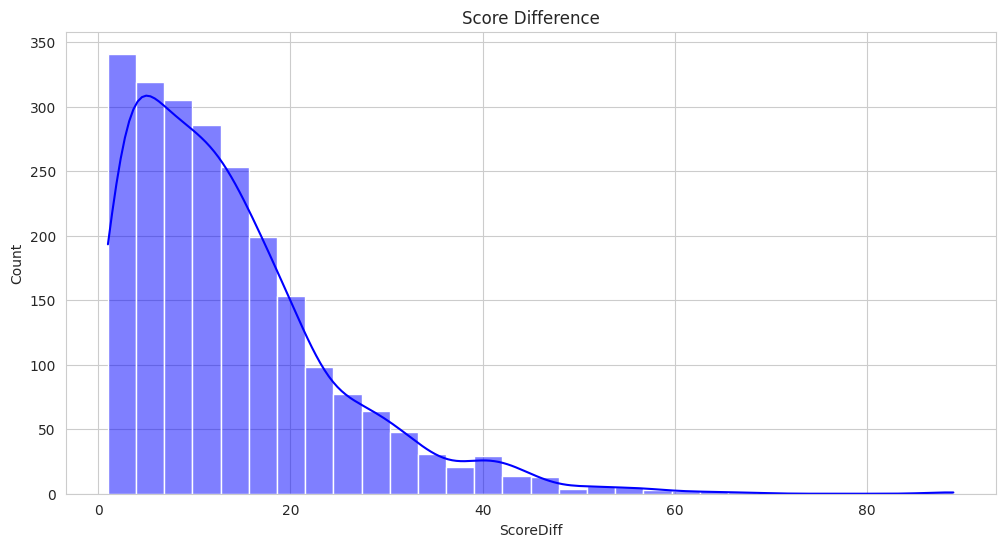

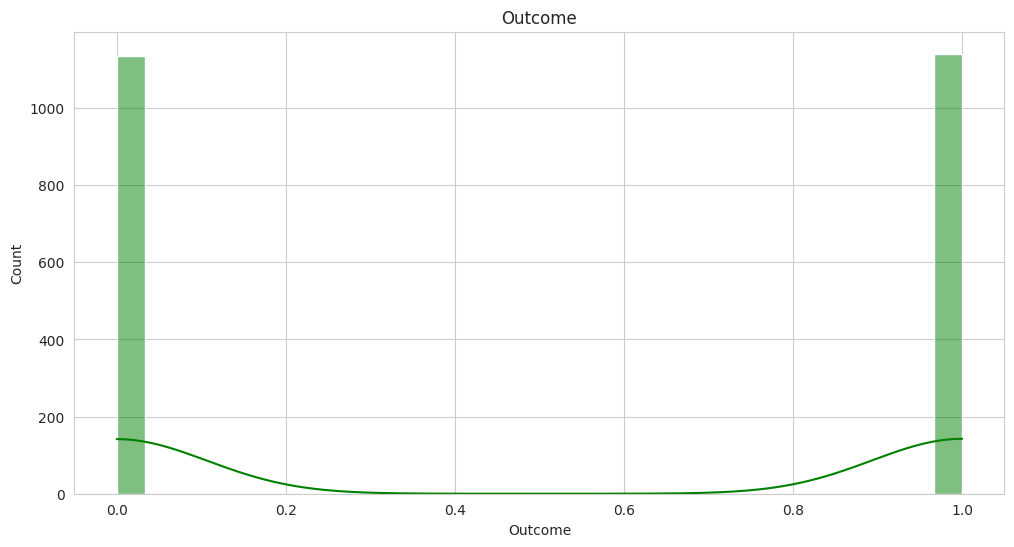

In [8]:
# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.histplot(all_games['ScoreDiff'], bins=30, kde=True, color='blue')
plt.title('Score Difference')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(all_games['Outcome'], bins=30, kde=True, color='green')
plt.title('Outcome')
plt.show()

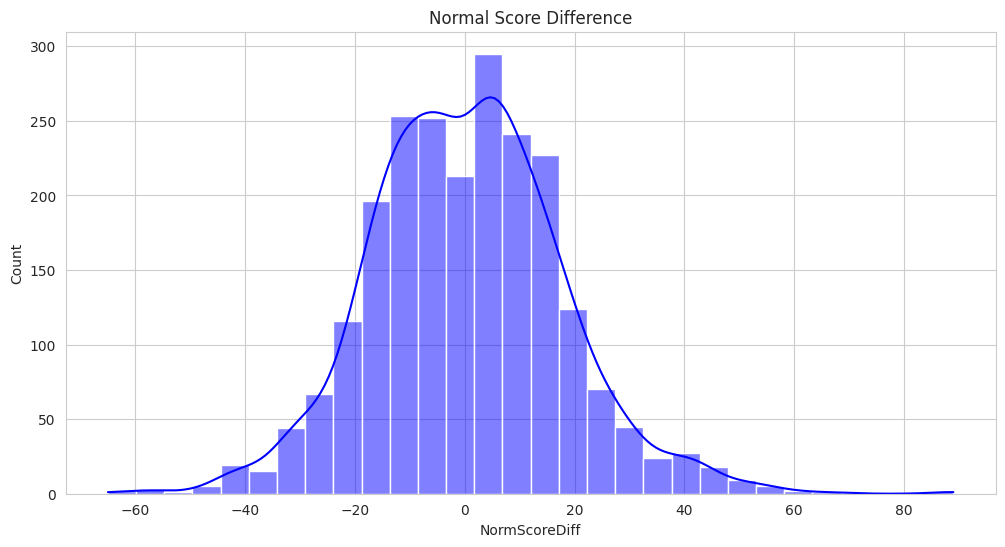

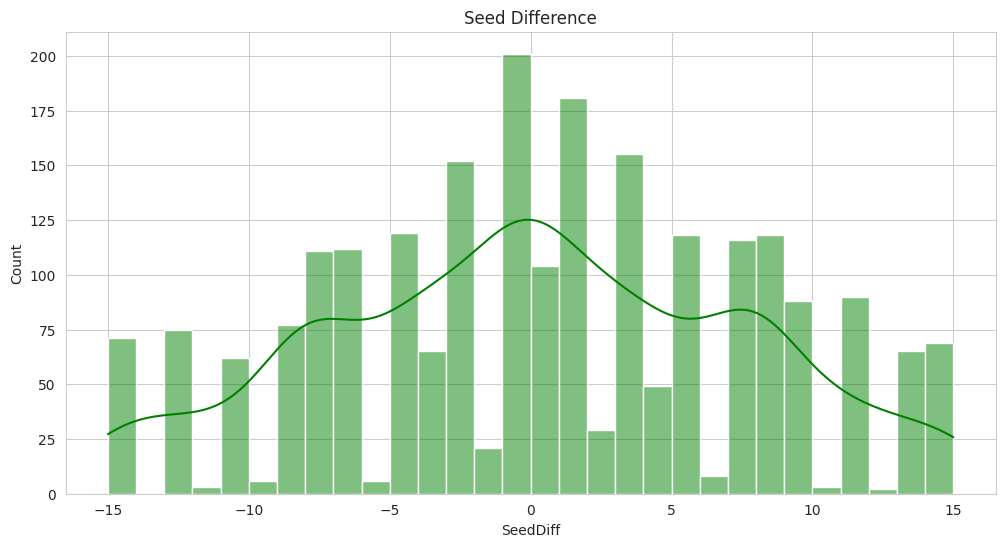

In [9]:
# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.histplot(all_games['NormScoreDiff'], bins=30, kde=True, color='blue')
plt.title('Normal Score Difference')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(all_games['SeedDiff'], bins=30, kde=True, color='green')
plt.title('Seed Difference')
plt.show()

In [10]:
# Data description and sample rows
print("Data Description:")
print(all_games.describe())
print("\nSample Rows:")
print(all_games.head())

Data Description:
            Season       DayNum      WTeamID       WScore      LTeamID  \
count  2276.000000  2276.000000  2276.000000  2276.000000  2276.000000   
mean   2014.702548   139.674868  2072.979789    75.747364  2075.132250   
std       5.911197     4.216212   979.246910    11.139983   977.954322   
min    2003.000000   134.000000  1101.000000    47.000000  1101.000000   
25%    2010.000000   137.000000  1257.000000    68.000000  1266.000000   
50%    2015.000000   138.000000  1410.000000    75.000000  1416.000000   
75%    2019.000000   141.000000  3246.000000    83.000000  3242.000000   
max    2024.000000   155.000000  3462.000000   140.000000  3465.000000   

            LScore         WLoc        NumOT         WFGM         WFGA  ...  \
count  2276.000000  2276.000000  2276.000000  2276.000000  2276.000000  ...   
mean     62.059315     2.826011     0.054482    27.019772    57.498243  ...   
std      11.009027     0.434299     0.256129     4.994331     7.609912  ...   

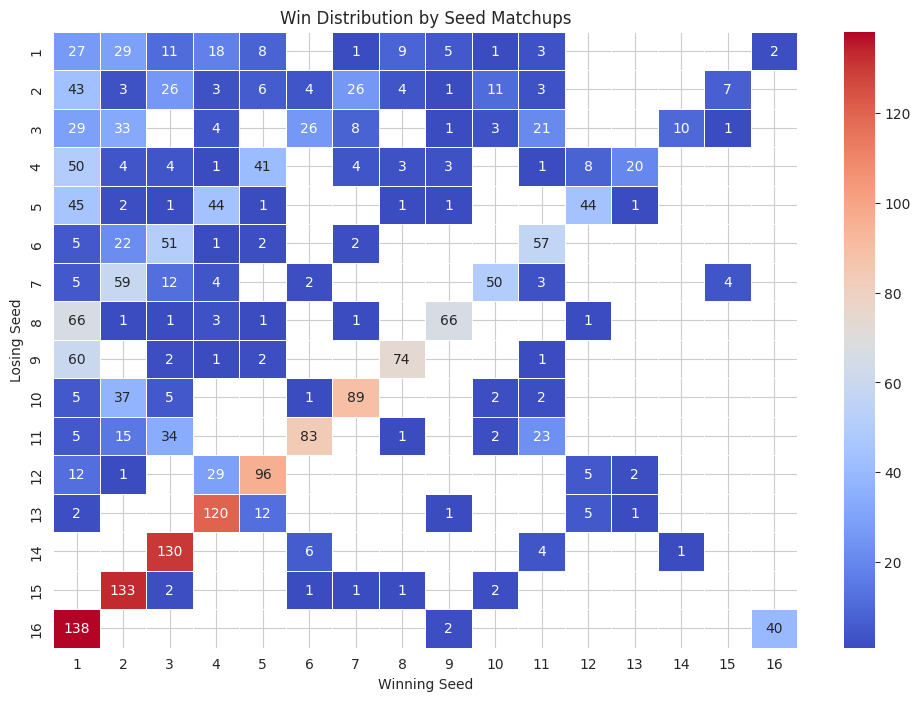

In [11]:
# Data visualization
# 1. Win Distribution by Seed Matchups
tourney_results['WSeed'] = tourney_results.apply(lambda r: seeds_dict.get(f"{r['Season']}_{r['WTeamID']}", np.nan), axis=1)
tourney_results['LSeed'] = tourney_results.apply(lambda r: seeds_dict.get(f"{r['Season']}_{r['LTeamID']}", np.nan), axis=1)
tourney_results['SeedDiff'] = tourney_results['WSeed'] - tourney_results['LSeed']

seed_win_counts = tourney_results.groupby(['WSeed', 'LSeed']).size().reset_index(name='WinCount')
plt.figure(figsize=(12, 8))
heatmap_data = seed_win_counts.pivot(index='LSeed', columns='WSeed', values='WinCount')
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)
plt.title("Win Distribution by Seed Matchups")
plt.xlabel("Winning Seed")
plt.ylabel("Losing Seed")
plt.show()

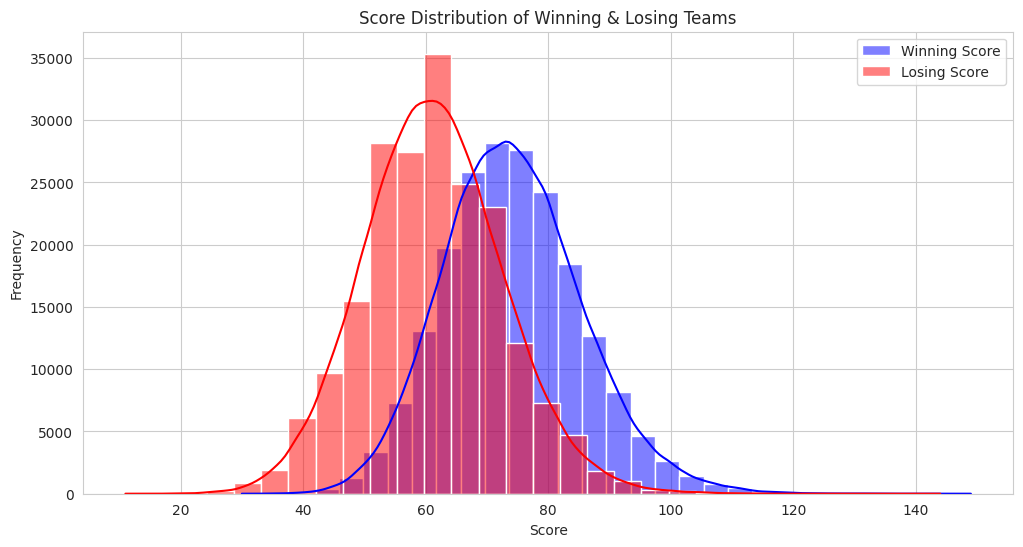

In [12]:
# 2. Score Distribution of Winning & Losing Teams
plt.figure(figsize=(12, 6))
sns.histplot(detailed_results['WScore'], bins=30, kde=True, color='blue', label='Winning Score')
sns.histplot(detailed_results['LScore'], bins=30, kde=True, color='red', label='Losing Score')
plt.legend()
plt.title("Score Distribution of Winning & Losing Teams")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


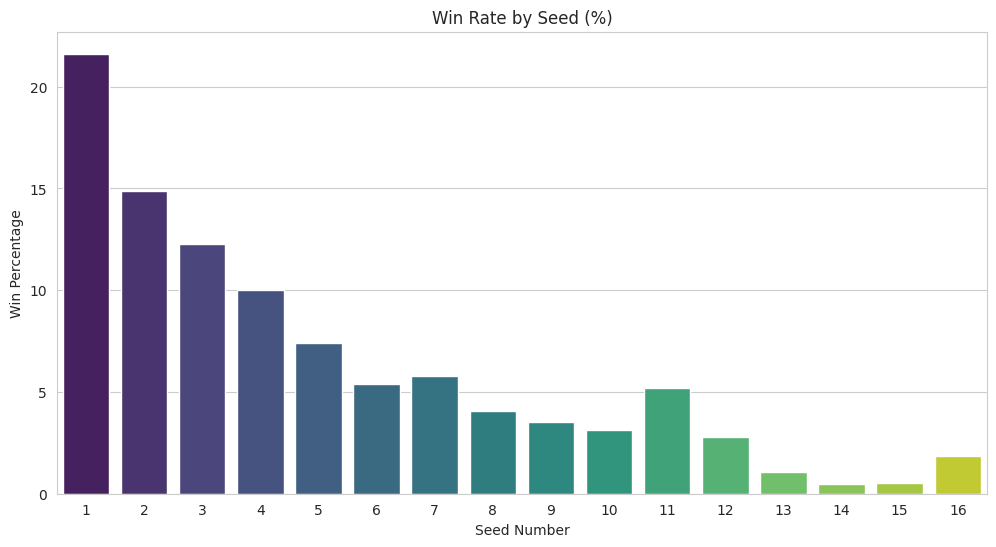

In [13]:
# 3. Win Rate by Seed
seed_win_rate = tourney_results.groupby('WSeed').size() / tourney_results.groupby('WSeed').size().sum() * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=seed_win_rate.index, y=seed_win_rate.values, palette="viridis")
plt.title("Win Rate by Seed (%)")
plt.xlabel("Seed Number")
plt.ylabel("Win Percentage")
plt.show()

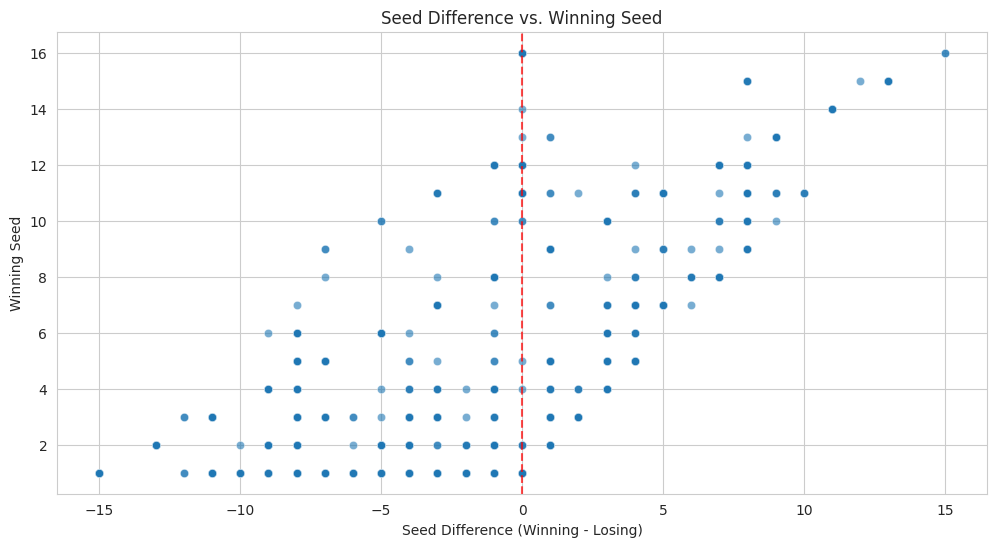

In [14]:
# 4. Seed Difference vs. Winning Seed
plt.figure(figsize=(12, 6))
sns.scatterplot(x=tourney_results['SeedDiff'], y=tourney_results['WSeed'], alpha=0.6)
plt.title("Seed Difference vs. Winning Seed")
plt.xlabel("Seed Difference (Winning - Losing)")
plt.ylabel("Winning Seed")
plt.axvline(0, linestyle="--", color="red", alpha=0.7)
plt.show()

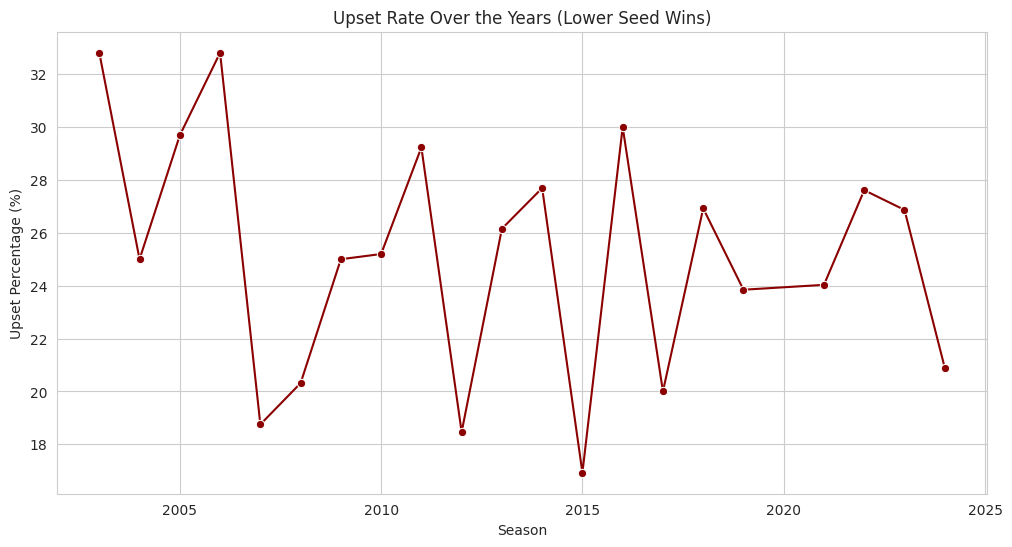

In [15]:
# 5. Upset Rate Over the Years (Lower Seed Wins)
tourney_results['Upset'] = (tourney_results['SeedDiff'] > 0).astype(int)
upset_rate_per_year = tourney_results.groupby('Season')['Upset'].mean() * 100
plt.figure(figsize=(12, 6))
sns.lineplot(x=upset_rate_per_year.index, y=upset_rate_per_year.values, marker="o", color="darkred")
plt.title("Upset Rate Over the Years (Lower Seed Wins)")
plt.xlabel("Season")
plt.ylabel("Upset Percentage (%)")
plt.show()

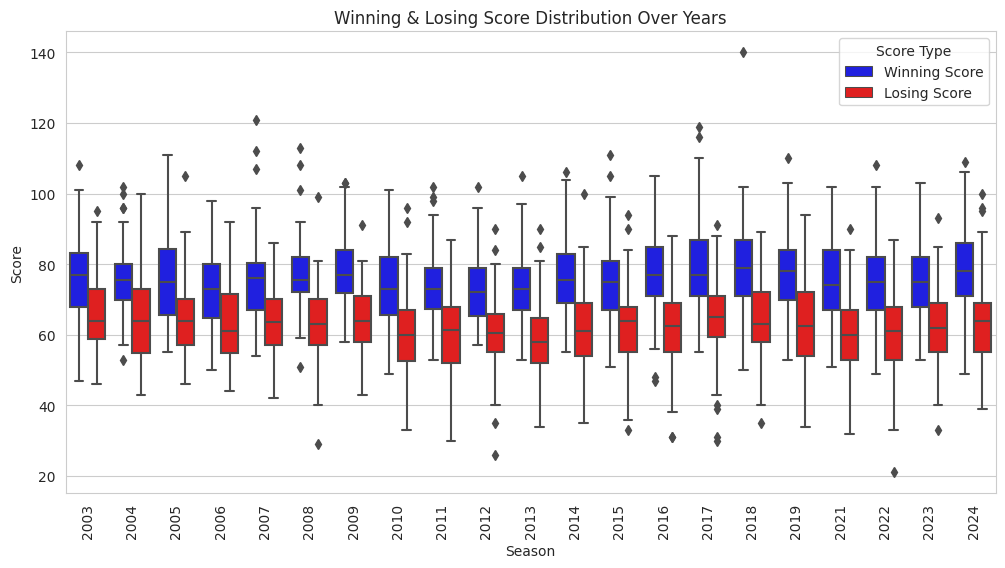

In [16]:
# 6. Winning & Losing Score Distribution Over Years
plt.figure(figsize=(12, 6))
tourney_results_melted = tourney_results.melt(id_vars=['Season'], value_vars=['WScore', 'LScore'], 
                                              var_name="Winner/Loser", value_name="Score")
sns.boxplot(data=tourney_results_melted, x='Season', y='Score', hue="Winner/Loser", 
            palette={"WScore": "blue", "LScore": "red"})
plt.title("Winning & Losing Score Distribution Over Years")
plt.xlabel("Season")
plt.ylabel("Score")
plt.xticks(rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["Winning Score", "Losing Score"], title="Score Type")
plt.show()

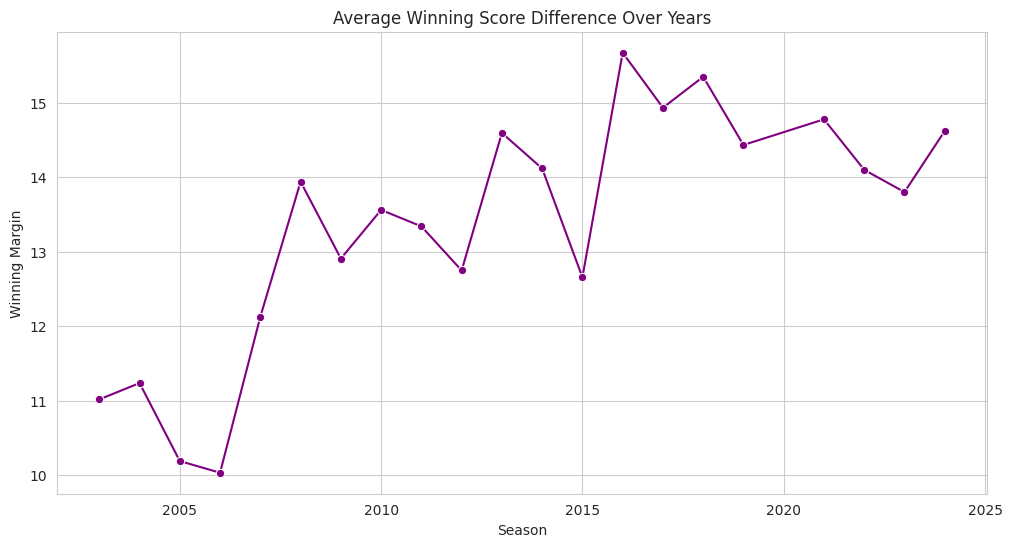

In [17]:
# 7. Average Winning Score Difference Over Years
tourney_results['ScoreDiff'] = tourney_results['WScore'] - tourney_results['LScore']
score_diff_trend = tourney_results.groupby('Season')['ScoreDiff'].mean()
plt.figure(figsize=(12, 6))
sns.lineplot(x=score_diff_trend.index, y=score_diff_trend.values, marker="o", color="purple")
plt.title("Average Winning Score Difference Over Years")
plt.xlabel("Season")
plt.ylabel("Winning Margin")
plt.show()

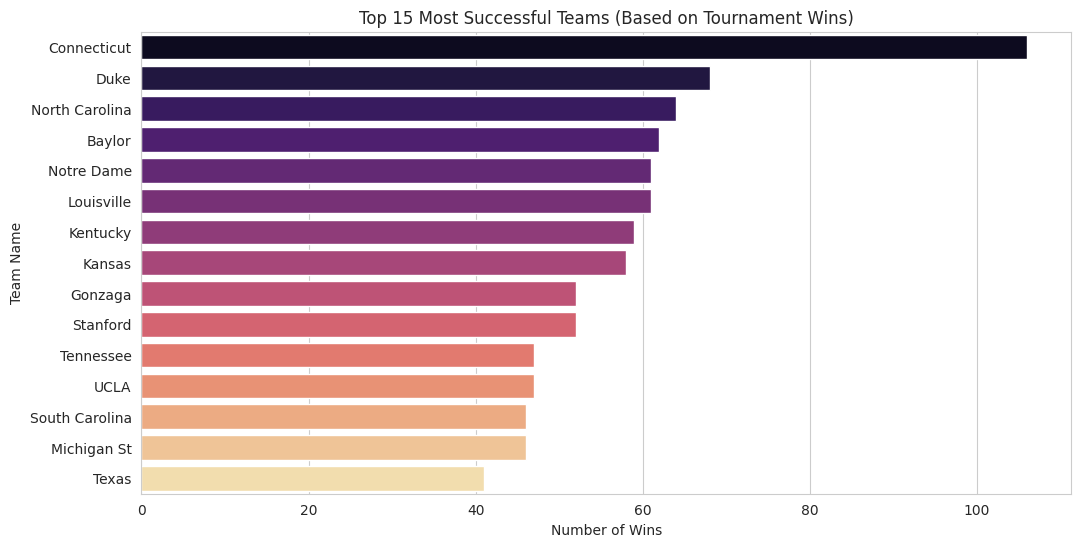

In [18]:
# 8. Top 15 Most Successful Teams (Based on Tournament Wins)
tourney_results = tourney_results.merge(combined_teams, left_on='WTeamID', right_on='TeamID', how='left')
tourney_results = tourney_results.rename(columns={'TeamName': 'WinningTeam'})
tourney_results = tourney_results.merge(combined_teams, left_on='LTeamID', right_on='TeamID', how='left')
tourney_results = tourney_results.rename(columns={'TeamName': 'LosingTeam'})
team_win_counts = tourney_results['WinningTeam'].value_counts().head(15)
plt.figure(figsize=(12, 6))
sns.barplot(x=team_win_counts.values, y=team_win_counts.index, palette="magma")
plt.title("Top 15 Most Successful Teams (Based on Tournament Wins)")
plt.xlabel("Number of Wins")
plt.ylabel("Team Name")
plt.show()

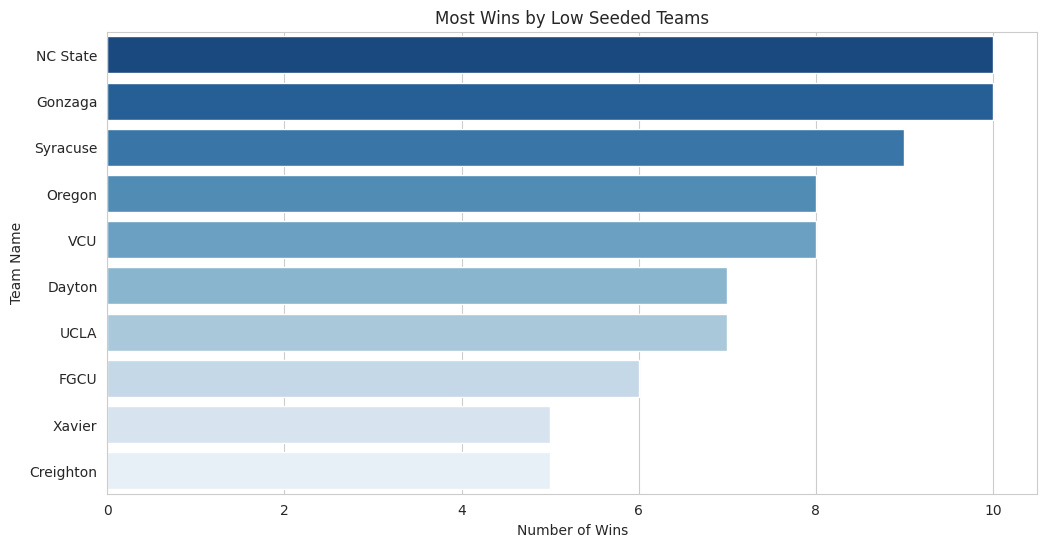

In [19]:
# 9.  Most Wins by Low Seeded Teams
cinderella_teams = tourney_results[tourney_results['WSeed'] >= 10]['WinningTeam'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=cinderella_teams.values, y=cinderella_teams.index, palette="Blues_r")
plt.title("Most Wins by Low Seeded Teams")
plt.xlabel("Number of Wins")
plt.ylabel("Team Name")
plt.show()

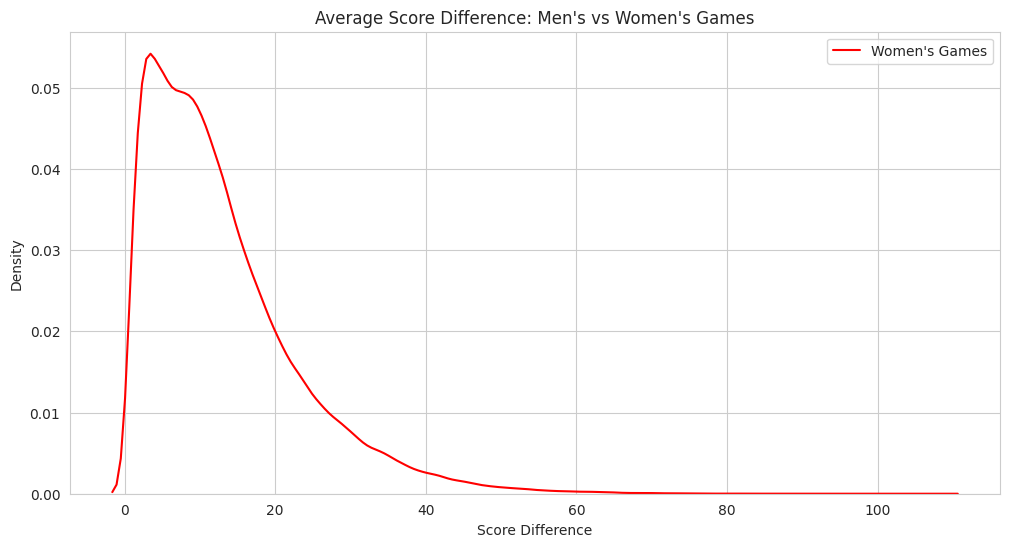

In [20]:
# 10. Men's vs Women's Teams: Average Score Difference
men_games = detailed_results[detailed_results['Season'] < 2000]  # Assuming Men's games are before 2000
women_games = detailed_results[detailed_results['Season'] >= 2000]  # Assuming Women's games are after 2000

men_score_diff = men_games['WScore'] - men_games['LScore']
women_score_diff = women_games['WScore'] - women_games['LScore']

plt.figure(figsize=(12, 6))
sns.kdeplot(men_score_diff, label="Men's Games", color="blue")
sns.kdeplot(women_score_diff, label="Women's Games", color="red")
plt.title("Average Score Difference: Men's vs Women's Games")
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.legend()
plt.show()

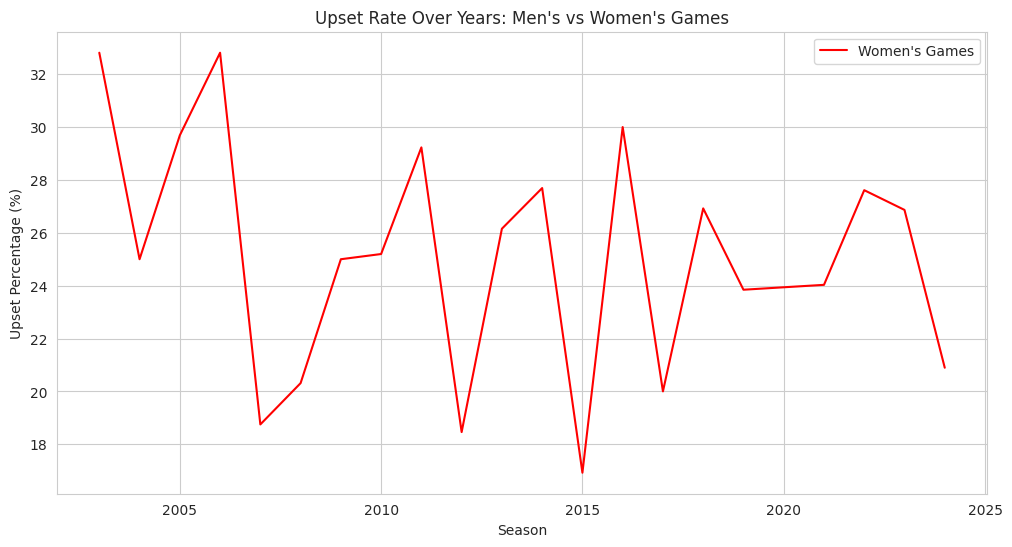

In [22]:
# 11. Men's vs Women's Teams: Upset Rate Over Years
men_tourney = tourney_results[tourney_results['Season'] < 2000]
women_tourney = tourney_results[tourney_results['Season'] >= 2000]
men_upset_rate = men_tourney.groupby('Season')['Upset'].mean() * 100
women_upset_rate = women_tourney.groupby('Season')['Upset'].mean() * 100

plt.figure(figsize=(12, 6))
sns.lineplot(x=men_upset_rate.index, y=men_upset_rate.values, label="Men's Games", color="blue")
sns.lineplot(x=women_upset_rate.index, y=women_upset_rate.values, label="Women's Games", color="red")
plt.title("Upset Rate Over Years: Men's vs Women's Games")
plt.xlabel("Season")
plt.ylabel("Upset Percentage (%)")
plt.legend()
plt.show()

In [23]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Model training with ensemble
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X = all_games[features].fillna(-1)
missing_cols = set(features) - set(submission.columns)
for c in missing_cols:
    submission[c] = 0

# Impute and scale the data
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Define classifiers
xgb = XGBClassifier(n_estimators=5000, device="gpu", learning_rate=0.03, max_depth=6, random_state=42)
rf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

In [24]:
# Create VotingClassifier
ensemble = VotingClassifier(estimators=[('xgb', xgb), ('rf', rf), ('lr', lr)], voting='soft')

In [25]:
# Fit the ensemble model
ensemble.fit(X_scaled, all_games['Outcome'])

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device='gpu',
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_r...
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=5000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=1000,
                                                     random_state=42)),
                             ('lr',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42))],
                 voting='soft')

In [26]:
# Predict probabilities
pred = ensemble.predict_proba(X_scaled)[:, 1].clip(0.001, 0.999)

In [27]:
# Evaluate the model
print(f'Log Loss: {log_loss(all_games["Outcome"], pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(all_games["Outcome"], pred)}')
print(f'Brier Score: {brier_score_loss(all_games["Outcome"], pred)}')

Log Loss: 0.23477303544934666
Mean Absolute Error: 0.20063961867569682
Brier Score: 0.05299292565520245


In [28]:
# Cross-validation
cv_scores = cross_val_score(ensemble, X_scaled, all_games['Outcome'], cv=5, scoring='neg_log_loss')
print(f'Cross-validated Log Loss: {-cv_scores.mean()}')

Cross-validated Log Loss: 0.5674260469646846


In [29]:
# Create submission file
sub_X = submission[features].fillna(-1)
sub_X_imputed = imputer.transform(sub_X)
sub_X_scaled = scaler.transform(sub_X_imputed)

submission['Pred'] = ensemble.predict_proba(sub_X_scaled)[:, 1].clip(0.001, 0.999)
submission[['ID', 'Pred']].to_csv('submission.csv', index=False)